In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
print(train.shape)
train.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
target = train['Transported']
train = train.drop('Transported', axis=1)
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


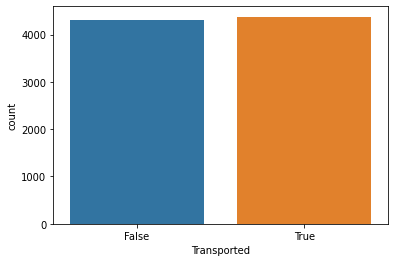

In [4]:
sns.countplot(x=target)
plt.show()

In [5]:
train.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object

In [6]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
dtype: int64

Корреляция числовый значений

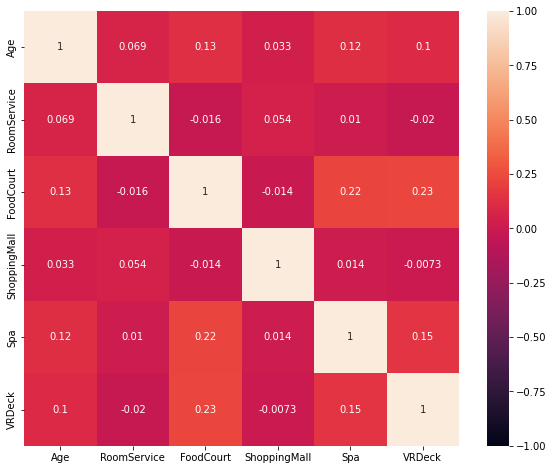

In [7]:
corr = train.corr()
plt.figure(figsize=(10, 8))
# sns.clustermap(corr, cmap='rocket_r')
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, vmin=-1, vmax=1,
            annot=True, square=True)
plt.show()

In [8]:
def prepare_data(df):
    df = df.rename(columns = lambda x: x.lower())
    df['deck'] = df['cabin'].apply(lambda x: 'Unknown' if x is np.nan else str(x)[0])
    df['num'] = df['cabin'].apply(lambda x: 'Unknown' if x is np.nan else str(x)[2])
    df['side'] = df['cabin'].apply(lambda x: 'Unknown' if x is np.nan else str(x)[-1])
    df = df.drop(['passengerid','name', 'cabin'], axis=1)
    
    quantity_columns = ['age', 'roomservice', 'foodcourt', 'spa', 'shoppingmall','vrdeck']
    qualitative_columns = ['homeplanet', 'cryosleep', 'destination', 'vip']
    
    imp_str = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Unknown')
    df[qualitative_columns] = imp_str.fit_transform(df[qualitative_columns])
    
    group_num = df.groupby(['homeplanet','vip'], as_index=False)[quantity_columns].mean()
    for q_col in quantity_columns:
        for g in group_num[['homeplanet', 'vip']].values:
            val = group_num.where((group_num['homeplanet']==g[0]) & (group_num['vip']==g[1]))[q_col].dropna().iloc[0]
            df.loc[(df.homeplanet == g[0]) & (df.vip == g[1]) & (df[q_col].isna()), q_col] = val
#     imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')
#     df[quantity_columns] = imp_numeric.fit_transform(df[quantity_columns])
    
    minmax_scaler = MinMaxScaler()
    df[quantity_columns] = minmax_scaler.fit_transform(df[quantity_columns])
    
    df = pd.get_dummies(df)
    return df

In [9]:
train = prepare_data(train)
print(train.shape)
train.head()

(8693, 43)


,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,homeplanet_Unknown,...,num_4,num_5,num_6,num_7,num_8,num_9,num_Unknown,side_P,side_S,side_Unknown
0,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
print(test.shape)
test.head()

(4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [11]:
test = prepare_data(test)
test.head()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,homeplanet_Unknown,...,num_4,num_5,num_6,num_7,num_8,num_9,num_Unknown,side_P,side_S,side_Unknown
0,0.341772,0.000000,0.000000,0.00000,0.000000,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.240506,0.000000,0.000356,0.00000,0.142260,0.000000,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0.392405,0.000000,0.000000,0.00000,0.000000,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.481013,0.000000,0.263206,0.00000,0.009121,0.026266,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.253165,0.000865,0.000000,0.07658,0.000000,0.000000,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [12]:
test_result = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
print(test_result.shape)
test_result.head()

(4277, 2)


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [13]:
x_train, x_val, y_train, y_val = train_test_split(train, target, test_size=0.33,
                                                    random_state=33)

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [16]:
# params = {'criterion' : ['gini', 'entropy'],
#           'n_estimators' : [150,200,250,300],
#           'max_depth': range(12,19),
#           'min_samples_split' : [2,3,4]}
# rfc = RandomForestClassifier()
# # params = {'n_neighbors' : range(5,25),
# #           'weights' : ['uniform', 'distance'],
# #           'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
# # knc = KNeighborsClassifier()
# clf = GridSearchCV(rfc, params)
# clf.fit(x_val, y_val)
# clf.best_params_

In [17]:
def scores(y_true, y_predict, y_predict_proba):
    print(f'accuracy: {accuracy_score(y_true, y_predict):.5f}')
    print(f'f1-score: {f1_score(y_true, y_predict):.5f}')
#     print(f'roc-auc score: {roc_auc_score(y_true, y_predict):.5f}')


In [18]:
# best_params = clf.best_params_
rfc2 = RandomForestClassifier(criterion='entropy', n_estimators=200, min_samples_split=2, max_depth=12).fit(x_train, y_train)
predict_test = rfc2.predict(test)
# predict_proba_test = rfc2.predict_proba(test)[:,1]

# scores(test_result['Transported'], predict_test, predict_proba_test)

In [19]:
a = pd.DataFrame(data={'column':rfc2.feature_names_in_,
                   'importance':rfc2.feature_importances_})\
.sort_values('importance', ascending=False)
per20 = round(len(a) * 0.8)
a = a.iloc[:per20,]
b = list(a.column)

In [20]:
rfc3 = RandomForestClassifier(criterion='entropy', n_estimators=200, min_samples_split=2, max_depth=12).fit(x_train[b], y_train)
predict_test2 = rfc3.predict(test[b])
confusion_matrix(test_result['Transported'], predict_test2)

array([[2065, 2212],
       [   0,    0]])

In [21]:
confusion_matrix(test_result['Transported'], predict_test)

array([[2041, 2236],
       [   0,    0]])

In [22]:
confusion_matrix(test_result['Transported'], predict_test)

array([[2041, 2236],
       [   0,    0]])

In [23]:
confusion_matrix(test_result['Transported'], predict_test)

array([[2041, 2236],
       [   0,    0]])

In [24]:
submission = pd.DataFrame(data={'PassengerId': test_result['PassengerId'],
                            'Transported': predict_test2})
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [25]:
submission.to_csv('submission.csv', index=False)